In [1]:
import tensorflow as tf

# 🔹 Force TensorFlow to use GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)  # Prevents memory overflow
        tf.config.set_visible_devices(gpus[0], 'GPU')  # Use only the first GPU if multiple exist
        print("✅ GPU is available and will be used.")
    except RuntimeError as e:
        print(e)
else:
    print("⚠️ No GPU detected, running on CPU.")


✅ GPU is available and will be used.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6300064621009689462
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1356070912
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11230010670465019187
physical_device_desc: "device: 0, name: NVIDIA RTX A500 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [3]:
import numpy as np

In [4]:
from keras.models import Model

In [5]:
import matplotlib.pyplot as plt

In [6]:
from sklearn.preprocessing import MinMaxScaler

In [7]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Model
from keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed, Dropout, LayerNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [8]:
# Load the dataset
file_path = '../csv/one-year-data.csv'
df = pd.read_csv(file_path, delimiter=',')

In [9]:
df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')
df.set_index('DateTime', inplace=True)

In [10]:
# Drop columns with more than 30% missing values
df.dropna(axis=1, thresh=int(0.7 * len(df)), inplace=True)

In [11]:
# Fill missing values by forward filling
df.ffill(inplace=True)

# Fill any remaining missing values by backward filling
df.bfill(inplace=True)

In [12]:
# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df.values)
df_scaled = pd.DataFrame(scaled_data, index=df.index, columns=df.columns)
df_scaled = df_scaled.astype(np.float32)

# Define sequence and prediction lengths
sequence_length = 2  # one week (168 hours if data is hourly)
prediction_length = 1  # predicting the next 24 hours

# Function to create sequences
def create_sequences(data, seq_length, pred_length):
    x, y = [], []
    for i in range(len(data) - seq_length - pred_length + 1):
        x.append(data[i:(i + seq_length)])
        y.append(data[(i + seq_length):(i + seq_length + pred_length)])
    return np.array(x, dtype=np.float32), np.array(y, dtype=np.float32)

In [13]:
# Create sequences
X, Y = create_sequences(df_scaled.values, sequence_length, prediction_length)

# Split data into training and test sets
train_size = int(0.7 * len(X))
X_train, Y_train = X[:train_size], Y[:train_size]
X_test, Y_test = X[train_size:], Y[train_size:]

In [14]:


# Define the input shape
input_layer = Input(shape=(sequence_length, df_scaled.shape[1]))

# 🔹 Encoder: Add an extra LSTM layer + Layer Normalization
encoder = LSTM(100, return_sequences=True)(input_layer)
encoder = LayerNormalization()(encoder)
encoder = LSTM(50, return_sequences=False)(encoder)
encoder = Dropout(0.2)(encoder)  # Dropout for regularization

# 🔹 Bottleneck Representation
bottleneck = RepeatVector(prediction_length)(encoder)

# 🔹 Decoder: Add an extra LSTM layer + Layer Normalization
decoder = LSTM(50, return_sequences=True)(bottleneck)
decoder = LayerNormalization()(decoder)
decoder = LSTM(100, return_sequences=True)(decoder)
decoder = Dropout(0.2)(decoder)  # Dropout for regularization

# 🔹 Output Layer: Dense layer with activation
output_layer = TimeDistributed(Dense(df_scaled.shape[1], activation="relu"))(decoder)

# 🔹 Build and Compile Model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mse')

# 🔹 Model Summary
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2, 71)]           0         
                                                                 
 lstm (LSTM)                 (None, 2, 100)            68800     
                                                                 
 layer_normalization (LayerN  (None, 2, 100)           200       
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 repeat_vector (RepeatVector  (None, 1, 50)            0         
 )                                                           

In [15]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')
# 🔹 Reduce learning rate when loss stops improving
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
history = model.fit(X_train, Y_train, epochs=10, batch_size=1024, validation_split=0.2, callbacks=[early_stopping], verbose=1)

Epoch 1/10
627/627 [==============================] - 36s 28ms/step - loss: 0.0198 - val_loss: 0.0083
Epoch 2/10
627/627 [==============================] - 16s 26ms/step - loss: 0.0040 - val_loss: 0.0066
Epoch 3/10
627/627 [==============================] - 17s 27ms/step - loss: 0.0028 - val_loss: 0.0061
Epoch 4/10
627/627 [==============================] - 14s 23ms/step - loss: 0.0021 - val_loss: 0.0072
Epoch 5/10
627/627 [==============================] - 15s 24ms/step - loss: 0.0016 - val_loss: 0.0082
Epoch 6/10
627/627 [==============================] - 16s 25ms/step - loss: 0.0013 - val_loss: 0.0089
Epoch 7/10
627/627 [==============================] - 15s 25ms/step - loss: 9.8457e-04 - val_loss: 0.0103
Epoch 8/10
627/627 [==============================] - 15s 23ms/step - loss: 7.4524e-04 - val_loss: 0.0100


168/168 [==============================] - 4s 10ms/step
Test RMSE: 2346.1279803113894


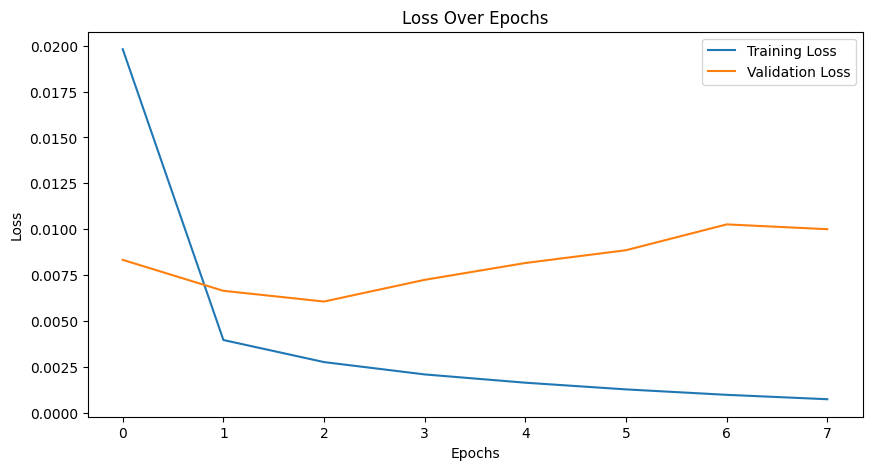

In [16]:
# Evaluate the model
predicted = model.predict(X_test, batch_size=2048)
predicted = scaler.inverse_transform(predicted.reshape(-1, df_scaled.shape[1])).reshape(predicted.shape)
Y_test_rescaled = scaler.inverse_transform(Y_test.reshape(-1, df_scaled.shape[1])).reshape(Y_test.shape)
rmse = np.sqrt(mean_squared_error(Y_test_rescaled.flatten(), predicted.flatten()))
print(f'Test RMSE: {rmse}')

# Plot the loss history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Optionally, save the model
#model.save('lstm_autoencoder_model.h5')


In [17]:
# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df.values)
df_scaled = pd.DataFrame(scaled_data, index=df.index, columns=df.columns)
df_scaled = df_scaled.astype(np.float32)

# Define sequence and prediction lengths
sequence_length = 2  # one week (168 hours if data is hourly)
prediction_length = 1  # predicting the next 24 hours

# Function to create sequences
def create_sequences(data, seq_length, pred_length):
    x, y = [], []
    for i in range(len(data) - seq_length - pred_length + 1):
        x.append(data[i:(i + seq_length)])
        y.append(data[(i + seq_length):(i + seq_length + pred_length)])
    return np.array(x, dtype=np.float32), np.array(y, dtype=np.float32)

In [18]:
# 🔹 Step 1: Predict the reconstruction for the test data
Y_pred = model.predict(X_test, batch_size=2048)

# 🔹 Step 2: Reshape the predictions to match the test set
Y_pred = Y_pred.reshape(Y_test.shape[0], Y_test.shape[1], Y_test.shape[2])

# 🔹 Step 3: Compute the reconstruction error (Mean Absolute Error)
mse = np.mean(np.abs(Y_test - Y_pred), axis=(1, 2))

# 🔹 Step 4: Define the anomaly detection threshold
threshold = np.percentile(mse, 95)  # 95th percentile as threshold
print(threshold)
print(f"Anomaly Detection Threshold: {threshold}")

# 🔹 Step 5: Detect anomalies (True if error exceeds threshold)
anomalies = mse > threshold

168/168 [==============================] - 2s 10ms/step
0.1087290428578854
Anomaly Detection Threshold: 0.1087290428578854


In [19]:
# 🔹 Step 4: Define the anomaly detection threshold
threshold = np.percentile(mse, 95)  # 95th percentile as threshold
print(threshold)
print(f"Anomaly Detection Threshold: {threshold}")

# 🔹 Step 5: Detect anomalies (True if error exceeds threshold)
anomalies = mse > threshold

0.1087290428578854
Anomaly Detection Threshold: 0.1087290428578854


In [20]:
df.reset_index(inplace=True)
# 🔹 Step 6: Create a DataFrame with DateTime, error values, and anomaly flags
anomaly_df = pd.DataFrame({
    "DateTime": df["DateTime"].iloc[-len(anomalies):].values,  # Match timestamps
    "Reconstruction_Error": mse,
    "Anomaly": anomalies  # Boolean flag (True = Anomaly)
})


In [21]:

# 🔹 Step 7: Filter only detected anomalies
anomaly_df = anomaly_df[anomaly_df["Anomaly"] == True]

# 🔹 Step 8: Save anomalies to a CSV file
anomaly_df.to_csv("detected_anomalies.csv", index=False)
print(f"🔴 Detected {len(anomaly_df)} anomalies, saved to detected_anomalies.csv")

🔴 Detected 17194 anomalies, saved to detected_anomalies.csv


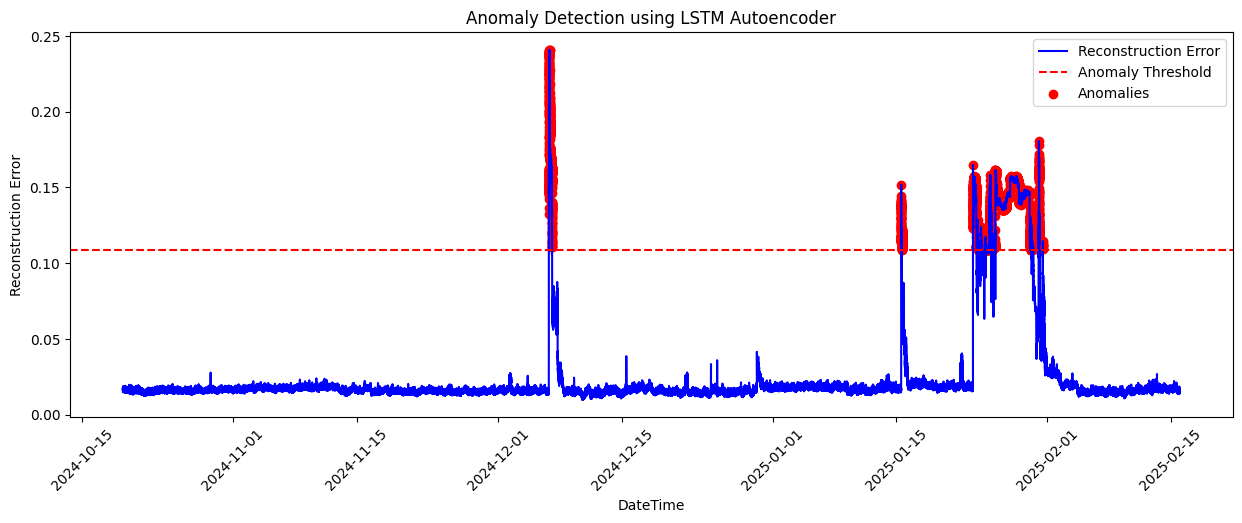

Top Contributing Features to Anomalies:
530R002D02.TI0036.MEAS    562.810203
dtype: float64
✅ Saved feature deviation analysis to anomaly_contributing_features.csv


In [22]:
# Reset index to make "DateTime" a column

# 🔹 Step 9: Plot reconstruction error over time and mark anomalies
plt.figure(figsize=(15, 5))
plt.plot(df["DateTime"].iloc[-len(mse):], mse, label="Reconstruction Error", color="blue")
plt.axhline(threshold, color="red", linestyle="--", label="Anomaly Threshold")
plt.scatter(anomaly_df["DateTime"], anomaly_df["Reconstruction_Error"], color="red", label="Anomalies", marker="o")
plt.xlabel("DateTime")
plt.ylabel("Reconstruction Error")
plt.legend()
plt.title("Anomaly Detection using LSTM Autoencoder")
plt.xticks(rotation=45)
plt.show()

# 🔹 Step 10: Identify the root cause of anomalies
# Extract data corresponding to anomalies
anomalous_data = df[df["DateTime"].isin(anomaly_df["DateTime"])]

# Compute deviation from normal values for target variables
target_columns = [
    '530R002D02.TI0036.MEAS'

]

feature_deviation = anomalous_data[target_columns] - df[target_columns].mean()

# Identify the most affected features
top_anomalous_features = feature_deviation.abs().mean().sort_values(ascending=False)

# 🔹 Step 11: Display the top contributing features
print("Top Contributing Features to Anomalies:")
print(top_anomalous_features.head(10))  # Show top 10 features

# 🔹 Step 12: Save feature deviation analysis
top_anomalous_features.to_csv("anomaly_contributing_features.csv")
print("✅ Saved feature deviation analysis to anomaly_contributing_features.csv")


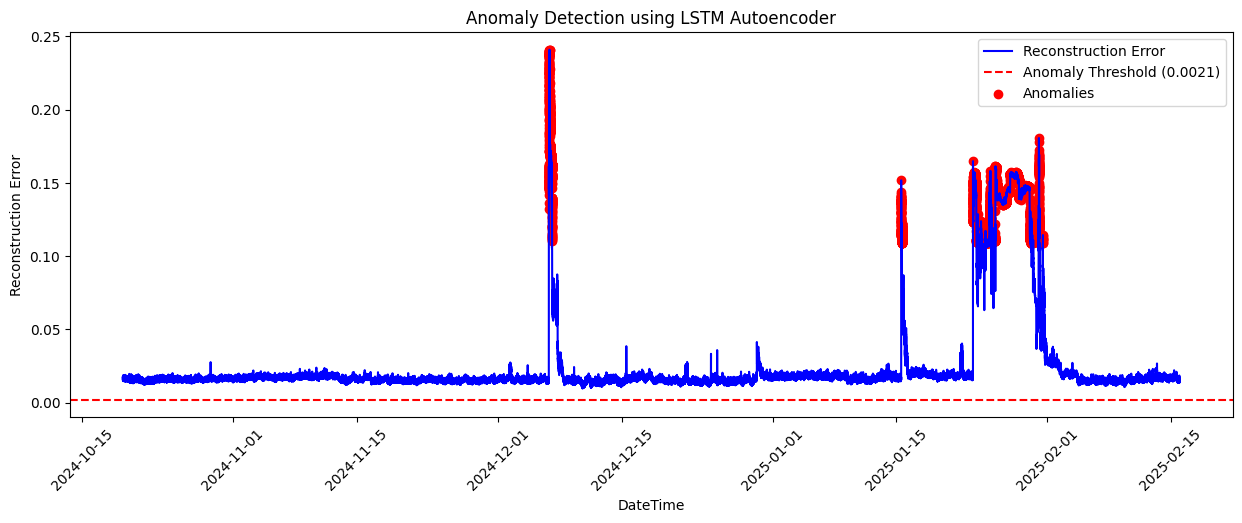

E:\apps\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
E:\apps\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


📌 **Top 5 Contributing Features to Anomalies:**
530K001S01.FI0007.MEAS        75948.135330
530UZ0001E01.FZI0008C.MEAS    74531.107590
530UZ0001E01.FZI0008A.MEAS    73311.239934
530UZ0001E01.FZI0008B.MEAS    71573.955312
530R001D01.FI0043.MEAS         2288.051460
dtype: float64

🔗 **Correlation with Target Variable (530R002D02.TI0036.MEAS):**
530K001S01.FI0007.MEAS        0.909561
530UZ0001E01.FZI0008C.MEAS    0.884974
530UZ0001E01.FZI0008A.MEAS    0.886248
530UZ0001E01.FZI0008B.MEAS    0.886598
530R001D01.FI0043.MEAS        0.933878
dtype: float64

✅ Saved feature deviation analysis to 'anomaly_contributing_features.csv'


In [23]:
import matplotlib.pyplot as plt
import pandas as pd

# 🔹 Step 9: Adjusting the Anomaly Threshold Dynamically
# Use mean + (X * std) as the threshold, where X is a sensitivity factor (default: 3)
sensitivity_factor = 3  # Adjust this based on experimentation
#threshold = mse.mean() + sensitivity_factor * mse.std()
threshold = 0.002100492059253156
# 🔹 Step 10: Plot Reconstruction Error and Mark Anomalies
plt.figure(figsize=(15, 5))
plt.plot(df["DateTime"].iloc[-len(mse):], mse, label="Reconstruction Error", color="blue")
plt.axhline(threshold, color="red", linestyle="--", label=f"Anomaly Threshold ({threshold:.4f})")
plt.scatter(anomaly_df["DateTime"], anomaly_df["Reconstruction_Error"], color="red", label="Anomalies", marker="o")
plt.xlabel("DateTime")
plt.ylabel("Reconstruction Error")
plt.legend()
plt.title("Anomaly Detection using LSTM Autoencoder")
plt.xticks(rotation=45)
plt.show()

# 🔹 Step 11: Identify the Root Cause of Anomalies
# Extract only rows where anomalies were detected
anomalous_data = df[df["DateTime"].isin(anomaly_df["DateTime"])]

# Compute deviation from normal values for **all** features
feature_deviation = anomalous_data.drop(columns=["DateTime"]) - df.drop(columns=["DateTime"]).mean()

# Identify the 5 most deviating features
top_anomalous_features = feature_deviation.abs().mean().sort_values(ascending=False).head(5)

# 🔹 Step 12: Compute Correlation with Target Variable
correlation_with_target = df.drop(columns=["DateTime"]).corrwith(df["530R002D02.TI0036.MEAS"])

# Filter correlation for only the top 5 features
correlation_top_features = correlation_with_target[top_anomalous_features.index]

# 🔹 Step 13: Display Results
print("📌 **Top 5 Contributing Features to Anomalies:**")
print(top_anomalous_features)

print("\n🔗 **Correlation with Target Variable (530R002D02.TI0036.MEAS):**")
print(correlation_top_features)

# 🔹 Step 14: Save the results
result_df = pd.DataFrame({"Deviation": top_anomalous_features, "Correlation": correlation_top_features})
result_df.to_csv("anomaly_contributing_features2.csv")
print("\n✅ Saved feature deviation analysis to 'anomaly_contributing_features.csv'")


In [25]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import MultiHeadAttention

# ✅ Capture Feature Names
feature_names = df_scaled.columns.to_list()

# ✅ Define Causal Attention Layer
class CausalAttention(tf.keras.layers.Layer):
    def __init__(self, num_heads, key_dim):
        super(CausalAttention, self).__init__()
        self.attention = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)

    def call(self, inputs):
        attn_output = self.attention(inputs, inputs)
        return attn_output

# ✅ Define batch size
batch_size = 1024
total_rows = df_scaled.shape[0]
num_batches = total_rows // batch_size

# ✅ Storage for causal outputs
all_causal_outputs = []

# ✅ Process dataset in batches
for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, total_rows)

    # Extract batch data
    batch_data = df_scaled.iloc[start_idx:end_idx, :].values
    batch_data = batch_data.reshape(1, batch_data.shape[0], batch_data.shape[1])

    # Apply causal attention
    causal_layer = CausalAttention(num_heads=4, key_dim=batch_data.shape[-1])
    causal_output = causal_layer(batch_data)

    # Store result
    all_causal_outputs.append(causal_output.numpy())

    print(f"✅ Processed Batch {i+1}/{num_batches}")

# ✅ Merge all batches into a single array
all_causal_outputs = np.concatenate(all_causal_outputs, axis=1)

# ✅ Save the final causal output
np.save("full_causal_output.npy", all_causal_outputs)

print("🚀 Causal Analysis Completed for Entire Dataset!")

✅ Processed Batch 1/1119
✅ Processed Batch 2/1119
✅ Processed Batch 3/1119
✅ Processed Batch 4/1119
✅ Processed Batch 5/1119
✅ Processed Batch 6/1119
✅ Processed Batch 7/1119
✅ Processed Batch 8/1119
✅ Processed Batch 9/1119
✅ Processed Batch 10/1119
✅ Processed Batch 11/1119
✅ Processed Batch 12/1119
✅ Processed Batch 13/1119
✅ Processed Batch 14/1119
✅ Processed Batch 15/1119
✅ Processed Batch 16/1119
✅ Processed Batch 17/1119
✅ Processed Batch 18/1119
✅ Processed Batch 19/1119
✅ Processed Batch 20/1119
✅ Processed Batch 21/1119
✅ Processed Batch 22/1119
✅ Processed Batch 23/1119
✅ Processed Batch 24/1119
✅ Processed Batch 25/1119
✅ Processed Batch 26/1119
✅ Processed Batch 27/1119
✅ Processed Batch 28/1119
✅ Processed Batch 29/1119
✅ Processed Batch 30/1119
✅ Processed Batch 31/1119
✅ Processed Batch 32/1119
✅ Processed Batch 33/1119
✅ Processed Batch 34/1119
✅ Processed Batch 35/1119
✅ Processed Batch 36/1119
✅ Processed Batch 37/1119
✅ Processed Batch 38/1119
✅ Processed Batch 39/

In [26]:
# Compute the mean absolute attention per feature
feature_importance = np.mean(np.abs(all_causal_outputs), axis=(0, 1))  # ✅ FIXED

# Get the top 5 most influential features
top_features_idx = np.argsort(feature_importance)[-5:]  # Indices of top features

# Convert indices to actual feature names
top_features = [feature_names[i] for i in top_features_idx]

print("🔹 Most Causally Influential Sensors:", top_features)


🔹 Most Causally Influential Sensors: ['530R002D02.TI0020.MEAS', '530R002D02.TI0064.MEAS', '530F001D01.PIC0023.MEAS', '530R002D02.TI0031.MEAS', '530R002D02.TI0034.MEAS']


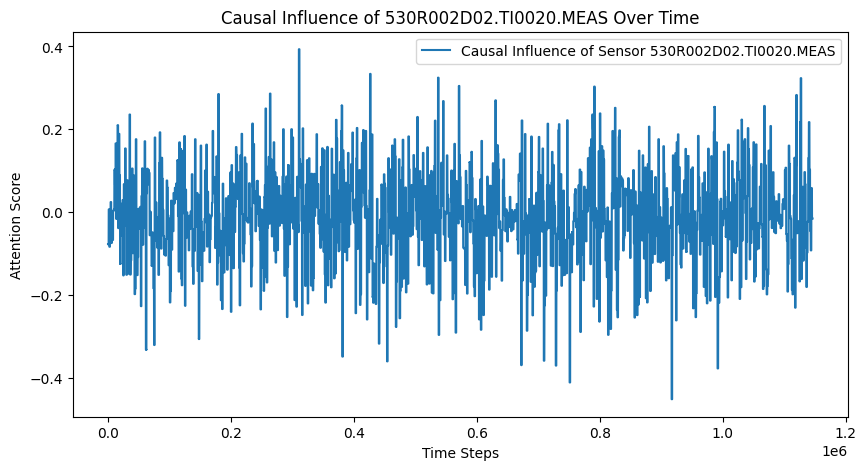

In [27]:

# ✅ Convert feature name to its corresponding index
sensor_idx = feature_names.index(top_features[0])  # FIXED

# Extract its causal values over time
sensor_causal_values = all_causal_outputs[0, :, sensor_idx]  

# Plot the causal effect of this sensor over time
plt.figure(figsize=(10, 5))
plt.plot(sensor_causal_values, label=f"Causal Influence of Sensor {top_features[0]}")
plt.xlabel("Time Steps")
plt.ylabel("Attention Score")
plt.title(f"Causal Influence of {top_features[0]} Over Time")
plt.legend()
plt.show()


In [32]:
# ✅ Set a threshold to filter the most contributing features
top_n_features = 10  # Keep only the top 10 most influential features

# ✅ Sort features by their causal influence
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# ✅ Keep only the top `top_n_features`
top_features_filtered = [feature for feature, score in sorted_features[:top_n_features]]

print("🔹 Most Contributing Features to Anomalies:", top_features_filtered)


🔹 Most Contributing Features to Anomalies: ['530R002D02.TI0034.MEAS', '530R002D02.TI0031.MEAS', '530F001D01.PIC0023.MEAS', '530R002D02.TI0064.MEAS', '530R002D02.TI0020.MEAS', '530UZ0001E01.LZI0012B.MEAS', '530UZ0001E01.TZI0057A.MEAS', '530UZ0001E01.LZI0012C.MEAS', '535INT920D01.TI0046.MEAS', '530R002D02.TI0039.MEAS']


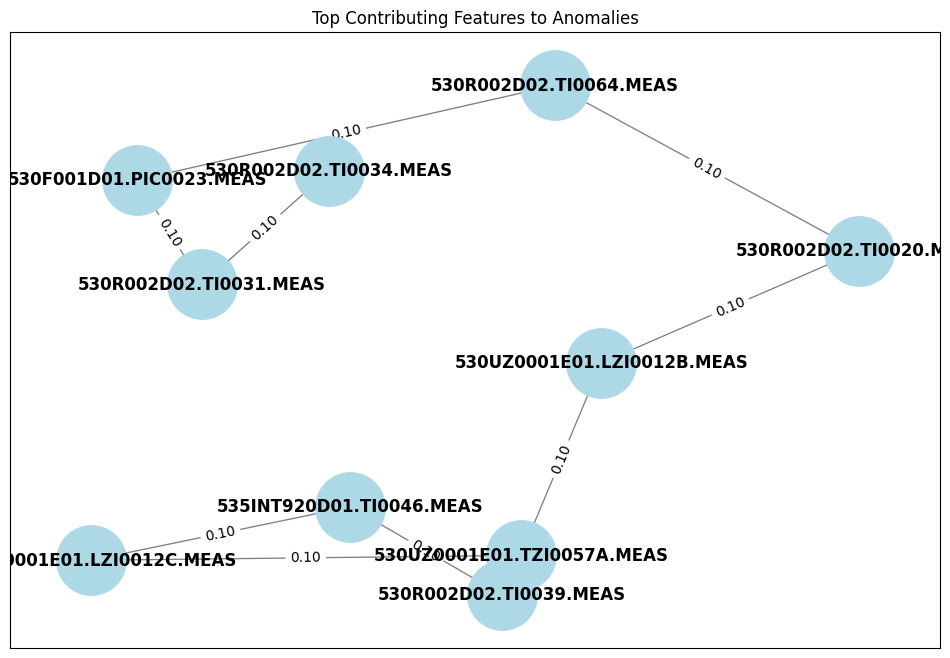

In [33]:
import networkx as nx


# ✅ Define a new graph for only top features
G_filtered = nx.DiGraph()

# ✅ Add only the most contributing features
G_filtered.add_nodes_from(top_features_filtered)

# ✅ Add strongest causal connections within these features
for i in range(len(top_features_filtered) - 1):
    cause = top_features_filtered[i]
    effect = top_features_filtered[i + 1]  # Assume sequential influence

    # Add directed edge (cause -> effect)
    G_filtered.add_edge(cause, effect, weight=feature_importance_dict[cause])

# ✅ Improve layout for readability
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_filtered, seed=42)  # Spread out nodes nicely

# ✅ Draw nodes
nx.draw_networkx_nodes(G_filtered, pos, node_color="lightblue", node_size=2500)

# ✅ Draw edges with thickness based on influence
edges = G_filtered.edges(data=True)
edge_weights = [d['weight'] for (_, _, d) in edges]
nx.draw_networkx_edges(G_filtered, pos, edgelist=edges, width=[w * 10 for w in edge_weights], edge_color="gray")

# ✅ Draw labels with better spacing
nx.draw_networkx_labels(G_filtered, pos, font_size=12, font_color="black", font_weight="bold")

# ✅ Add edge labels for importance scores
edge_labels = {(u, v): f"{G_filtered[u][v]['weight']:.2f}" for u, v in G_filtered.edges}
nx.draw_networkx_edge_labels(G_filtered, pos, edge_labels=edge_labels, font_size=10)

plt.title("Top Contributing Features to Anomalies")
plt.show()
